## Introduction

[The Voice Afrique francophone](http://www.voxafrica.com/thevoice/) (TVA) is a singing competition where contestants are chosen based on thier voice during a performance where the coaches face the public and can only hear them. The show started on Sturday, 15 October and will go until February, the 4th 2017. The show is broadcasted on [Vox Africa](http://www.voxafrica.com/thevoice/). For more information, you can look [here](http://www.camerpost.com/cameroun-the-voice-afrique-francophone-postulants-donnent-de-voix/).

In this post series, we will use various [data sience](https://en.wikipedia.org/wiki/Data_science) tools to analyse the tweets we collected about the event.

### Data collection

To collect the data we needed in our analysis, we will the [REST API](https://dev.twitter.com/rest/public) provided by Twitter. From the Twitter documentation:

>The REST APIs provide programmatic access to read and write Twitter data. Create a new Tweet, read user profile and follower data, and more. The REST API identifies Twitter applications and users using OAuth; responses are in JSON format.

Twitter also give to users a [Streaming API](https://dev.twitter.com/streaming/overview) which is a way of getting tweets about an event in real time. But since we don't monitor the data in real time, will stick on the rest api. And in order to make our life easier, we will rely on [Tweepy](http://www.tweepy.org/), "An easy-to-use Python library for accessing the Twitter API". For persitence, we use [MongoDB](https://www.mongodb.com/) to store the tweets in the `thevoice` *collection* under the `search` database. How to set up MongoDB is beyond the scope of this post. Visit the [documentation](http://docs.tweepy.org/en/v3.5.0/getting_started.html) to get started with Tweepy.

The code below is in the `searh_and_store.py` file and it assumes you have mongoDB running on your local machine.

```python
import os
import sys
import json
import time

import tweepy
import pymongo

host = "localhost"
port = 27017

consumer_key = "CONSUMER KEY"
consumer_secret = "CONSUMER SECRET"

db = pymongo.MongoClient(host, port).search # search's database

auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

if not api:
    print("Can't Authenticate!")
    sys.exit(-1)

query = "#TheVoiceAfrique OR TheVoiceAfriqueFrancophone OR \
        #teamLokua OR #teamCharlotte OR #teamSinguila OR #teamAsalfo OR \
        #equipeLokua OR #equipeCharlotte OR #equipeSinguila OR equipeAsalfo"

max_tweets = 1000000
ids = set()

count = 0
for tweet in tweepy.Cursor(api.search, q=query, lang="fr", count=100).items(max_tweets):
    tweet = tweet._json
    
    if "retweeted_status" in tweet.keys():
        rt_tweet = tweet["retweeted_status"] # grab the retweeted tweet
        id_str = rt_tweet["id_str"]
        if not(id_str in ids):
            ids.add(id_str)
            id = db.thevoice.insert_one(rt_tweet).inserted_id
            print(id)
    
    id_str = tweet["id_str"]
    if not(id_str in ids):
        ids.add(id_str)
        id = db.thevoice.insert_one(tweet).inserted_id
        print(id)
    
    count += 1

print("Downloaded {} tweets".format(count))
```

The code above connects to Twitter, search for tweets with the terms in the `query` variable, store the result in the `thevoice` collection if the tweet is not already downloaded (with search queries, we often get redondant results). The code also check if it is a retweet and if so, store the original tweet if not already in the database (with search queries, the original tweet of a retweet is often missed). I ran the script on **November, 07 2016** at **1pm** and it collected **4998** tweets (inluding retweets ~ **61%**) ranging from **14/10/2016** to **07/11/2016**.

In [1]:
from collections import defaultdict
from datetime import datetime

import pandas as pd
import pymongo
import altair

In [2]:
host = "localhost"
port = 27017

db = pymongo.MongoClient(host, port).search

In [7]:
def strptime(ts):
    cformat = "%a %b %d %H:%M:%S %Y"
    uformat = "%a %b %d %H:%M:%S %z %Y"
    
    ctime = datetime.strptime(ts, uformat).ctime()
    return datetime.strptime(ctime, cformat)

In [8]:
tweets = pd.DataFrame({"created_at": [tweet["created_at"] 
                                      for tweet in db.thevoice.find() if not("retweeted_status" in tweet)]})

In [9]:
tweets = tweets.assign(created=tweets.created_at.apply(strptime))
tweets = tweets.drop("created_at", axis=1)
tweets["count"] = 1

print("Number of tweets: {}".format(len(tweets)))

Number of tweets: 2942


### Tweets frequency

We use [Altair](https://altair-viz.github.io/) to visualize the tweets frequency.

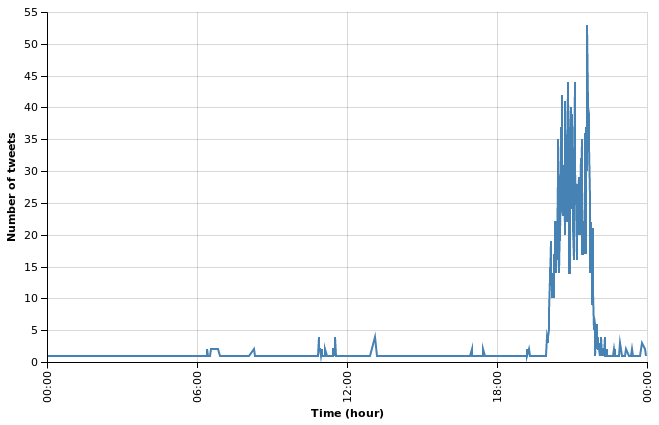

In [10]:
altair.Chart(tweets).mark_line().encode(
    x=altair.X("created", timeUnit="hoursminutes",
               scale=altair.Scale(nice="hour"),
               axis=altair.Axis(title="Time (hour)"),
              ),
    y=altair.Y("count", aggregate="sum",
               axis=altair.Axis(title="Number of tweets"),
              ),
).configure_cell(
    width=600,
)

With this graph, we can see that viewers are talking about the event only during the show, around 8pm and 10pm. Before and after that, it is a complete silence. In the [next post](https://dadaromeo.github.io/the-voice-afrique-tweets-mining-part-2) we will start ask our data questions. Thanks for following.

### Related posts

- [Mining Twitter Data with Python (Part 1: Collecting data)](https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/)